In [26]:
import os
import cv2
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import hdbscan

# Device fix: check CUDA first, then MPS, fallback CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Create output directories if needed
os.makedirs("/kaggle/working/frames_masked/matt", exist_ok=True)
os.makedirs("/kaggle/working/frames_masked/orsi", exist_ok=True)
os.makedirs("/kaggle/working/frames_masked/ryan", exist_ok=True)

Using device: cuda


In [27]:
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

# Load YOLO model (replace yolov8n.pt with your shark detector weights if any)
yolo_model = YOLO("/kaggle/input/yolo-marine/sharktrack.pt")
yolo_model.to(device)

# Load SAM model
sam_checkpoint = "/kaggle/input/sammodel/sam_vit_h_4b8939.pth"
sam_model_type = "vit_h"

sam = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

In [29]:
#data_dir = Path("/kaggle/input/thresher-frames")
#output_dir = Path("/kaggle/working/frames_masked")

data_dir = Path("/kaggle/input/thresher-subclips-main")
output_dir = Path("/kaggle/working/subclips_frames_masked")

def get_masks_from_boxes(image_np, boxes):
    predictor.set_image(image_np)

    boxes_array = np.array(boxes, dtype=np.float32)
    boxes_tensor = torch.from_numpy(boxes_array).to(device)
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes_tensor, image_np.shape[:2])

    masks_t, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    # masks_t shape: (N, 1, H, W) or (N, H, W)
    masks_np = masks_t.cpu().numpy()
    # Remove singleton dims if present
    if masks_np.ndim == 4:
        masks_np = np.squeeze(masks_np, axis=1)  # now (N, H, W)

    masks = []
    for mask in masks_np:
        masks.append(mask)
    return masks

max_per_folder = 104

for folder in ['thresher_subclips']:
#for folder in ['matt', 'orsi', 'ryan']:
    saved_count = 0
    folder_path = data_dir / folder
    save_folder = output_dir / folder
    save_folder.mkdir(parents=True, exist_ok=True)

    for img_path in sorted(folder_path.glob("*.[pj][pn]g")):
        if saved_count >= max_per_folder:
            break

        # Load image as numpy
        img_np = np.array(Image.open(img_path).convert("RGB"))

        # Detect sharks
        results = yolo_model(str(img_path))
        boxes = []
        for result in results:
            for box in result.boxes.xyxy.cpu().numpy():
                boxes.append(box)

        if len(boxes) == 0:
            continue

        # Get masks from boxes
        masks = get_masks_from_boxes(img_np, boxes)

        # Take only the largest mask
        largest_mask = None
        max_area = 0
        for mask in masks:
            mask = np.squeeze(mask).astype(bool)
            area = np.sum(mask)
            if area > max_area:
                max_area = area
                largest_mask = mask
        
        if largest_mask is None:
            continue  # skip if no valid mask
        
        combined_mask = largest_mask


        # Apply mask to image: black background + shark region preserved
        masked_img_np = img_np.copy()
        masked_img_np[~combined_mask] = 0

        # Save masked image
        save_path = save_folder / img_path.name
        Image.fromarray(masked_img_np).save(save_path)

        saved_count += 1
        if saved_count % 10 == 0:
            print(f"{folder}: Saved {saved_count} masked images")

    print(f"Done with folder {folder}, total saved: {saved_count}")


image 1/1 /kaggle/input/thresher-subclips-main/thresher_subclips/GP_MINA_20250103_4_1_frame1.png: 384x640 1 elasmobranch, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/thresher-subclips-main/thresher_subclips/GP_MINA_20250103_4_1_frame2.png: 384x640 1 elasmobranch, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/thresher-subclips-main/thresher_subclips/GP_MINA_20250103_4_1_frame3.png: 384x640 1 elasmobranch, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/thresher-subclips-main/thresher_subclips/GP_MINA_20250103_4_1_frame4.png: 384x640 1 elasmobranch, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/input/thresher-subclips-main/thresher_subclips/GP_MINA_20250103_4_1_frame5.png:

In [30]:
class SharkImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        self.index_to_video = []

        for video_dir in sorted(os.listdir(root_dir)):
            video_path = os.path.join(root_dir, video_dir)
            if not os.path.isdir(video_path): continue

            for filename in sorted(os.listdir(video_path)):
                if filename.endswith((".jpg", ".png")):
                    full_path = os.path.join(video_path, filename)
                    self.samples.append(full_path)
                    self.index_to_video.append(video_dir)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        img_bgr = cv2.imread(img_path)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_clahe = clahe.apply(gray)
        gray_rgb = cv2.cvtColor(gray_clahe, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(gray_rgb)

        if self.transform:
            img = self.transform(img)

        return img, img_path, self.index_to_video[idx]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
])

dataset = SharkImageDataset("/kaggle/working/frames_masked", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
print(f"Dataset size: {len(dataset)}")

Dataset size: 90


In [31]:
model = timm.create_model("vit_base_patch16_224.dino", pretrained=True)
model.eval()
model.to(device)

@torch.no_grad()
def extract_cls_features(dataloader, model, device):
    features = []
    paths = []
    video_names = []

    for imgs, img_paths, video_ids in dataloader:
        imgs = imgs.to(device)
        outputs = model.forward_features(imgs)
        cls_tokens = outputs[:, 0]
        features.append(cls_tokens.cpu())
        paths.extend(img_paths)
        video_names.extend(video_ids)

    features = torch.cat(features, dim=0)
    return features, paths, video_names

features, image_paths, video_ids = extract_cls_features(loader, model, device)
print("Extracted features shape:", features.shape)

Extracted features shape: torch.Size([90, 768])


In [32]:
features_np = features.numpy()
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(features_np)

num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_outliers = np.sum(cluster_labels == -1)

print(f"HDBSCAN found {num_clusters} clusters")
print(f"Number of outliers: {num_outliers}")

HDBSCAN found 4 clusters
Number of outliers: 62


In [33]:
import torch.nn as nn

class ClusterMemory(nn.Module):
    def __init__(self, feature_dim, num_clusters, momentum=0.2):
        super(ClusterMemory, self).__init__()
        self.feature_dim = feature_dim
        self.num_clusters = num_clusters
        self.momentum = momentum

        # Initialize cluster centroids buffer
        self.register_buffer("centroids", torch.zeros(num_clusters, feature_dim))

    def update_centroids(self, features, labels):
        # features: (batch_size, feature_dim)
        # labels: (batch_size,) with cluster IDs

        with torch.no_grad():
            for i in range(self.num_clusters):
                mask = (labels == i)
                if mask.sum() == 0:
                    continue
                cluster_feats = features[mask]
                centroid_batch = cluster_feats.mean(dim=0)

                # Momentum update of centroid
                self.centroids[i] = self.centroids[i] * self.momentum + centroid_batch * (1 - self.momentum)
                self.centroids[i] = F.normalize(self.centroids[i], p=2, dim=0)

    def forward(self):
        return self.centroids

# Prepare initial centroids by averaging features per cluster
init_centroids = []
for c in range(num_clusters):
    idxs = np.where(cluster_labels == c)[0]
    centroid = features[idxs].mean(dim=0)
    init_centroids.append(centroid)
init_centroids = torch.stack(init_centroids, dim=0).to(device)
init_centroids = F.normalize(init_centroids, p=2, dim=1)

cluster_memory = ClusterMemory(feature_dim=features.shape[1], num_clusters=num_clusters, momentum=0.2).to(device)
cluster_memory.centroids.copy_(init_centroids)

# Filter out noise (label == -1) indices and keep only confident data
confident_indices = np.where(cluster_labels != -1)[0]
confident_subset = torch.utils.data.Subset(dataset, confident_indices)
confident_loader = DataLoader(confident_subset, batch_size=32, shuffle=True)

path_to_index = {p: i for i, p in enumerate(image_paths)}

class ClusterContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ClusterContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels, cluster_memory):
        features = F.normalize(features, p=2, dim=1)  # (B, D)
        centroids = cluster_memory()  # (num_clusters, D)

        # Compute similarity between features and centroids
        sim_matrix = torch.matmul(features, centroids.t()) / self.temperature  # (B, num_clusters)

        # Create positive mask: sample belongs to cluster i
        labels = labels.long()
        pos_mask = torch.zeros_like(sim_matrix).to(features.device)
        pos_mask[torch.arange(len(labels)), labels] = 1.0

        # Calculate log-softmax
        log_prob = F.log_softmax(sim_matrix, dim=1)

        # Loss: negative log likelihood of positive cluster
        loss = - (pos_mask * log_prob).sum(dim=1).mean()

        return loss

contrastive_loss_fn = ClusterContrastiveLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [34]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}")
    model.train()
    epoch_loss = 0

    for imgs, paths, video_ids in confident_loader:
        imgs = imgs.to(device)
        feats = model.forward_features(imgs)[:, 0]
        feats = F.normalize(feats, p=2, dim=1)

        batch_indices = torch.tensor([path_to_index[p] for p in paths], dtype=torch.long).to(device)
        batch_labels = torch.tensor(cluster_labels, device=device)[batch_indices]

        loss = contrastive_loss_fn(feats, batch_labels, cluster_memory)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update cluster centroids with current batch features and labels
        cluster_memory.update_centroids(feats.detach(), batch_labels)

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(confident_loader)
    print(f"Avg loss: {avg_loss:.4f}")


Epoch 1
Avg loss: 0.6335

Epoch 2
Avg loss: 0.8504

Epoch 3
Avg loss: 0.3828

Epoch 4
Avg loss: 0.0286

Epoch 5
Avg loss: 0.0204

Epoch 6
Avg loss: 0.0057

Epoch 7
Avg loss: 0.0016

Epoch 8
Avg loss: 0.0013

Epoch 9
Avg loss: 0.0016

Epoch 10
Avg loss: 0.0018

Epoch 11
Avg loss: 0.0015

Epoch 12
Avg loss: 0.0010

Epoch 13
Avg loss: 0.0006

Epoch 14
Avg loss: 0.0004

Epoch 15
Avg loss: 0.0002

Epoch 16
Avg loss: 0.0001

Epoch 17
Avg loss: 0.0001

Epoch 18
Avg loss: 0.0001

Epoch 19
Avg loss: 0.0001

Epoch 20
Avg loss: 0.0001



Cluster 0


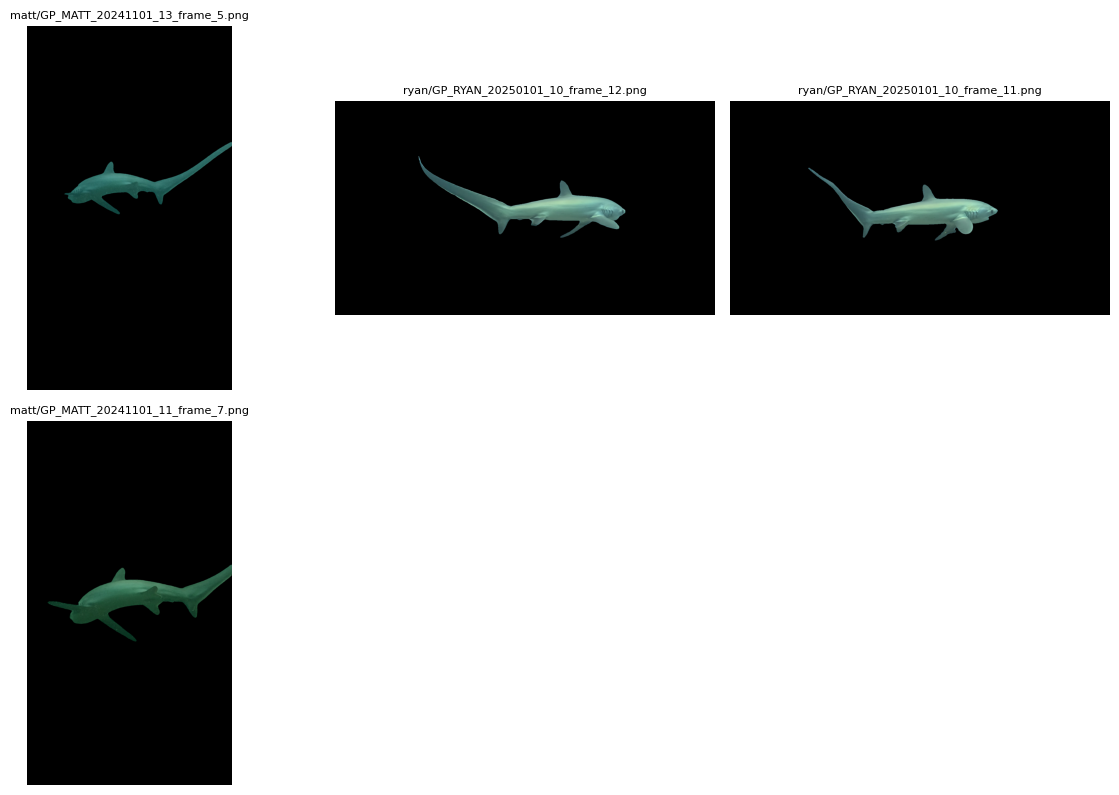


Cluster 1


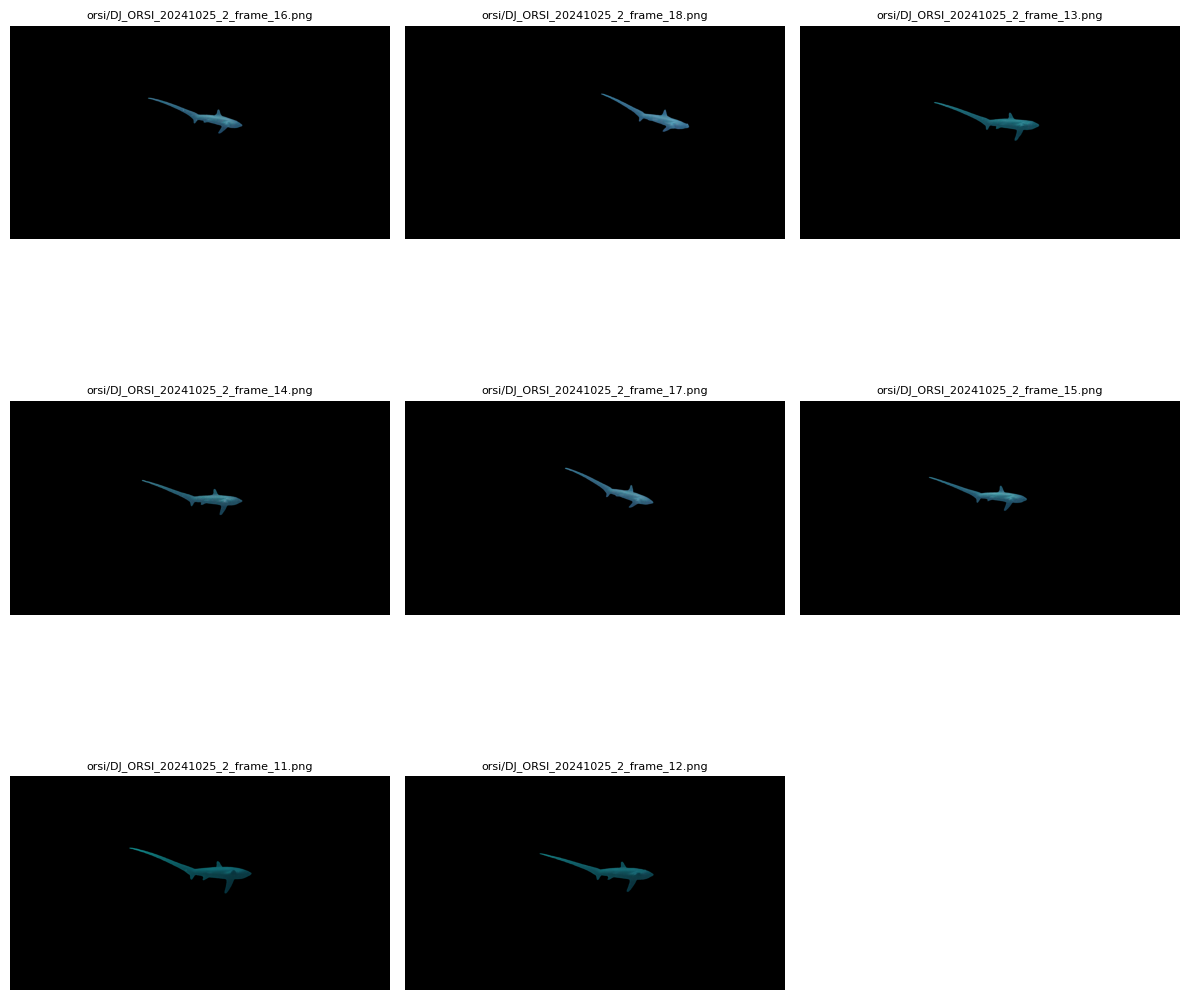


Cluster 2


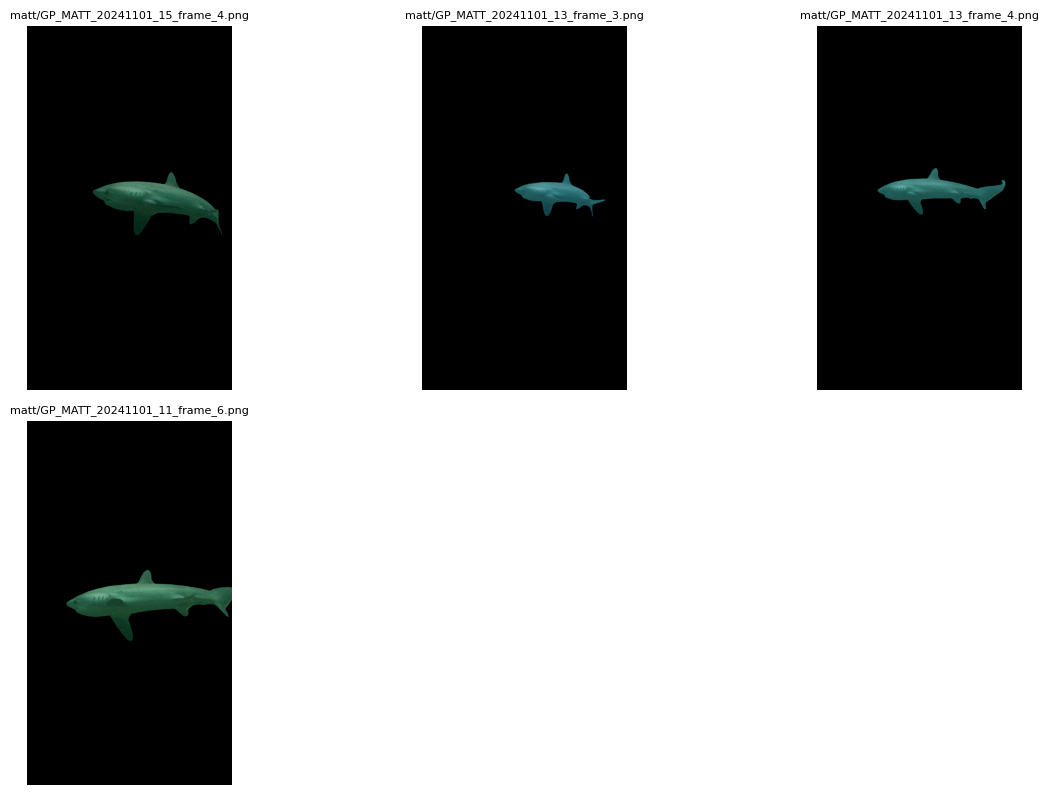


Cluster 3


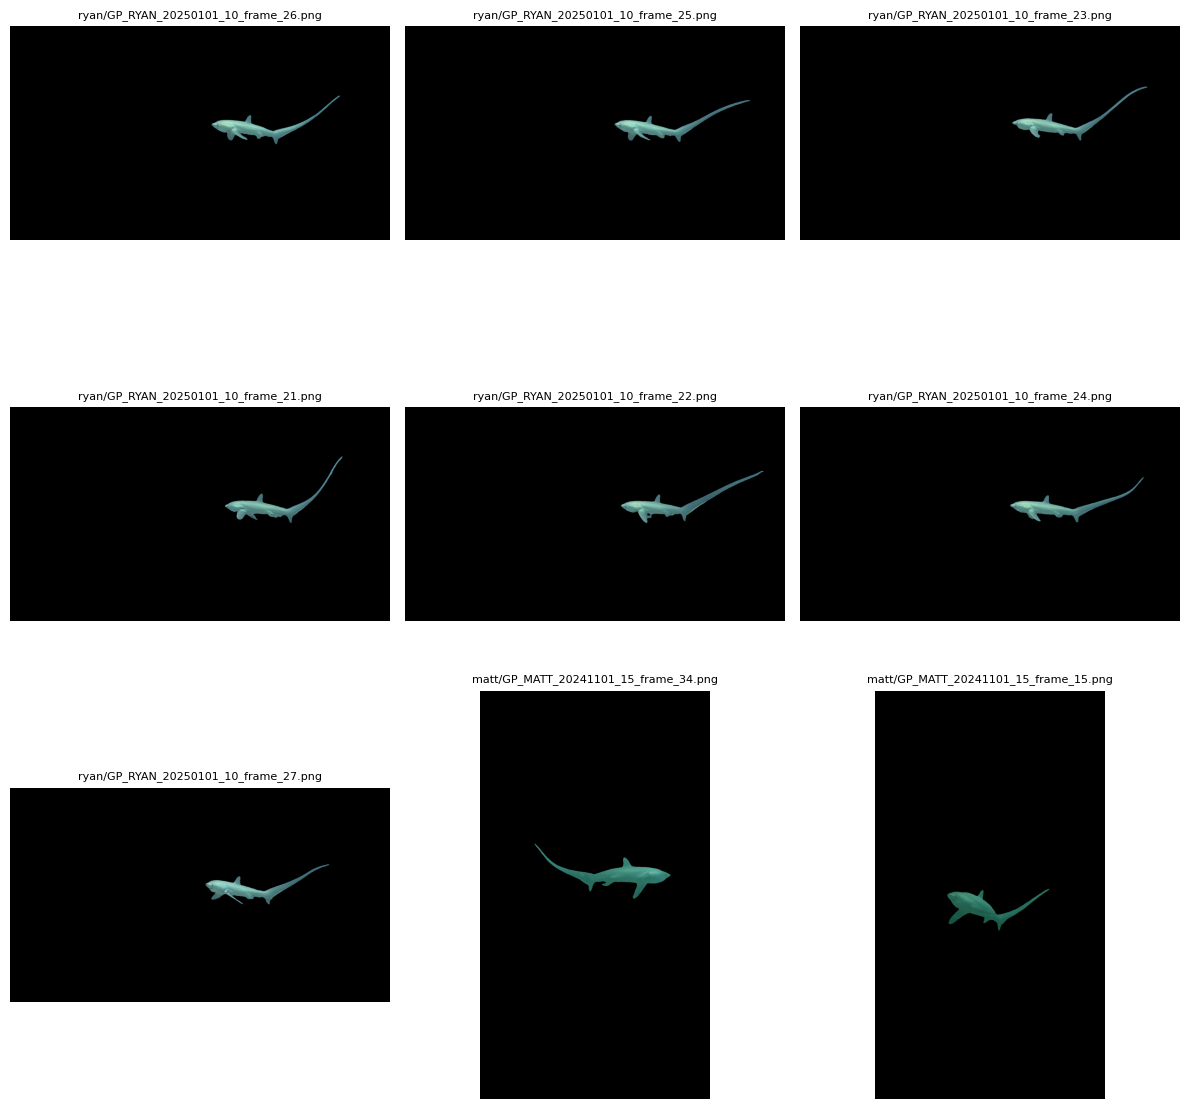

In [44]:
def show_ranked_images_by_cluster(cluster_memory, image_paths, cluster_labels, cluster_id, top_k=9):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_feats = cluster_memory.centroids[cluster_id].unsqueeze(0)  # (1, D)

    # For sorting, compute cosine similarity of each sample in cluster to centroid
    sample_feats = features[cluster_indices].to(device)
    sims = F.cosine_similarity(sample_feats, cluster_feats, dim=1)
    sorted_indices = torch.argsort(sims, descending=True)
    sorted_indices = sorted_indices[:top_k]

    cols = min(3, top_k)
    rows = math.ceil(top_k / cols)
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, idx in enumerate(sorted_indices.cpu().numpy()):
        path = image_paths[cluster_indices[idx]]
        img = Image.open(path)
        clip = os.path.basename(os.path.dirname(path))
        fname = os.path.basename(path)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{clip}/{fname}", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

unique_clusters = [c for c in range(num_clusters)]

for cluster_id in unique_clusters[:10]:
    print(f"\nCluster {cluster_id}")
    show_ranked_images_by_cluster(cluster_memory, image_paths, cluster_labels, cluster_id, top_k=9)

In [36]:
import shutil
shutil.make_archive('/kaggle/working/frames_masked', 'zip', '/kaggle/working/frames_masked')
print("Zipped frames_masked folder to /kaggle/working/frames_masked.zip")

Zipped frames_masked folder to /kaggle/working/frames_masked.zip


In [ ]:
#rm -rf /kaggle/working/*

In [37]:
from pyefd import elliptic_fourier_descriptors
from skimage import measure
import cv2
import numpy as np
from collections import defaultdict

# Helper to extract largest contour
def extract_largest_contour(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    return largest.squeeze()  # shape: (N, 2)

# Get EFDs for all masks
efd_by_cluster = defaultdict(list)
path_to_cluster = {p: int(lbl) for p, lbl in zip(image_paths, cluster_labels) if lbl != -1}


for path in image_paths:
    cluster_id = path_to_cluster.get(path)
    if cluster_id is None:
        continue

    mask_img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        continue
    mask_bin = (mask_img > 0).astype(np.uint8)

    contour = extract_largest_contour(mask_bin)
    if contour is None or len(contour) < 10:
        continue

    efd = elliptic_fourier_descriptors(contour, order=10, normalize=True).flatten()
    efd_by_cluster[cluster_id].append(efd)

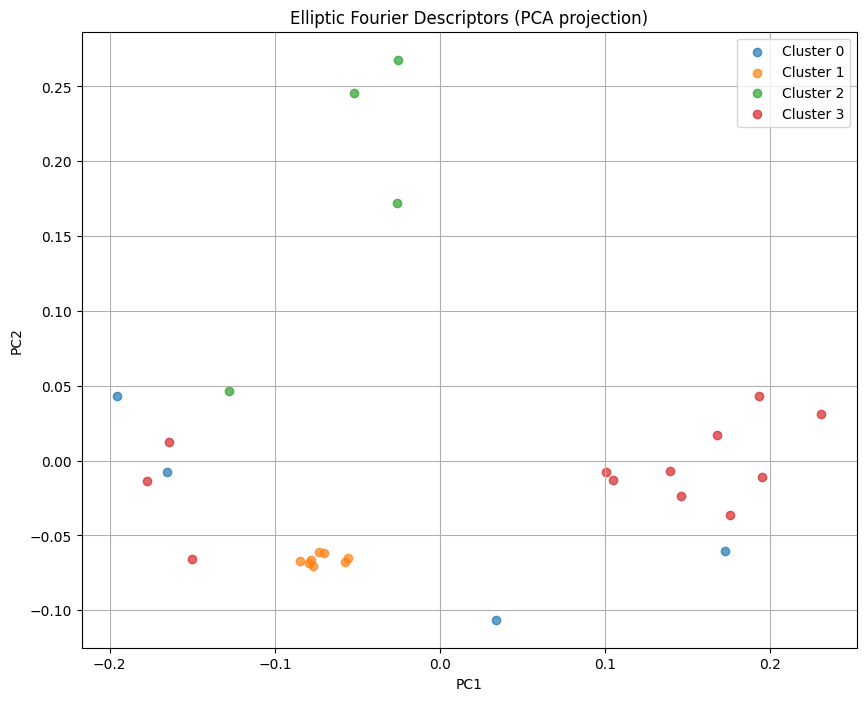

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare data for PCA
all_efds = []
all_labels = []

for cluster_id, efd_list in efd_by_cluster.items():
    for efd in efd_list:
        all_efds.append(efd)
        all_labels.append(cluster_id)

all_efds = np.array(all_efds)
all_labels = np.array(all_labels)

# PCA
pca = PCA(n_components=2)
efds_pca = pca.fit_transform(all_efds)

# Plot
plt.figure(figsize=(10, 8))
for cid in np.unique(all_labels):
    idx = all_labels == cid
    plt.scatter(efds_pca[idx, 0], efds_pca[idx, 1], label=f"Cluster {cid}", alpha=0.7)
plt.legend()
plt.title("Elliptic Fourier Descriptors (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [39]:
from scipy.spatial.distance import cdist

# Compute mean EFD for each cluster
mean_efds = {cid: np.mean(efds, axis=0) for cid, efds in efd_by_cluster.items()}

# Distance matrix between clusters
cluster_ids = sorted(mean_efds.keys())
centroids = np.array([mean_efds[cid] for cid in cluster_ids])
dist_matrix = cdist(centroids, centroids)

print("Inter-cluster EFD distance matrix:")
print(dist_matrix)

Inter-cluster EFD distance matrix:
[[          0     0.15544     0.22861     0.16462]
 [    0.15544           0     0.27451     0.17468]
 [    0.22861     0.27451           0     0.25098]
 [    0.16462     0.17468     0.25098           0]]


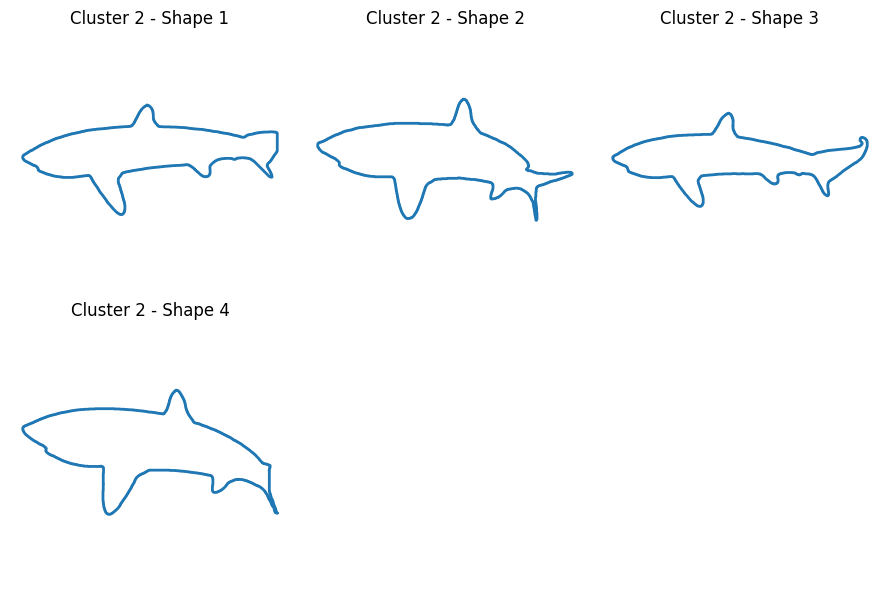

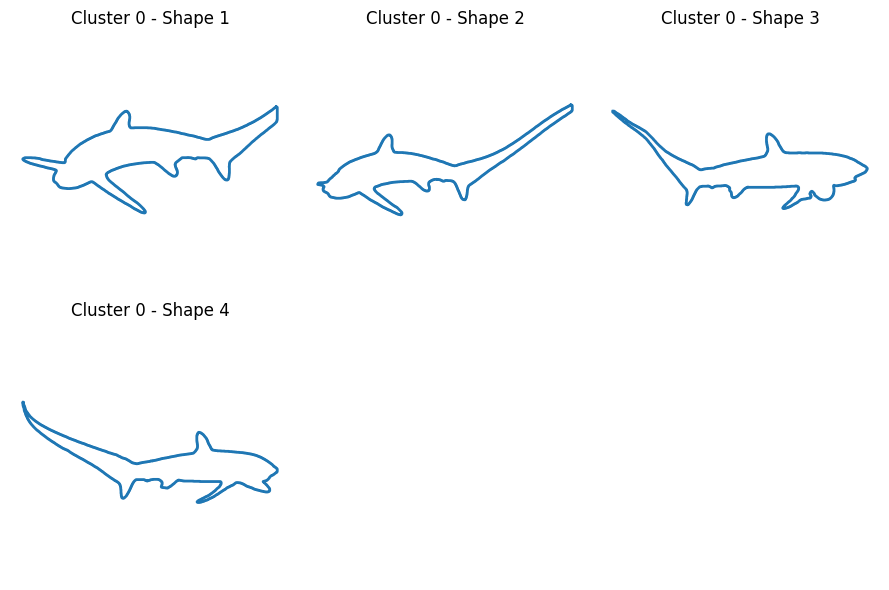

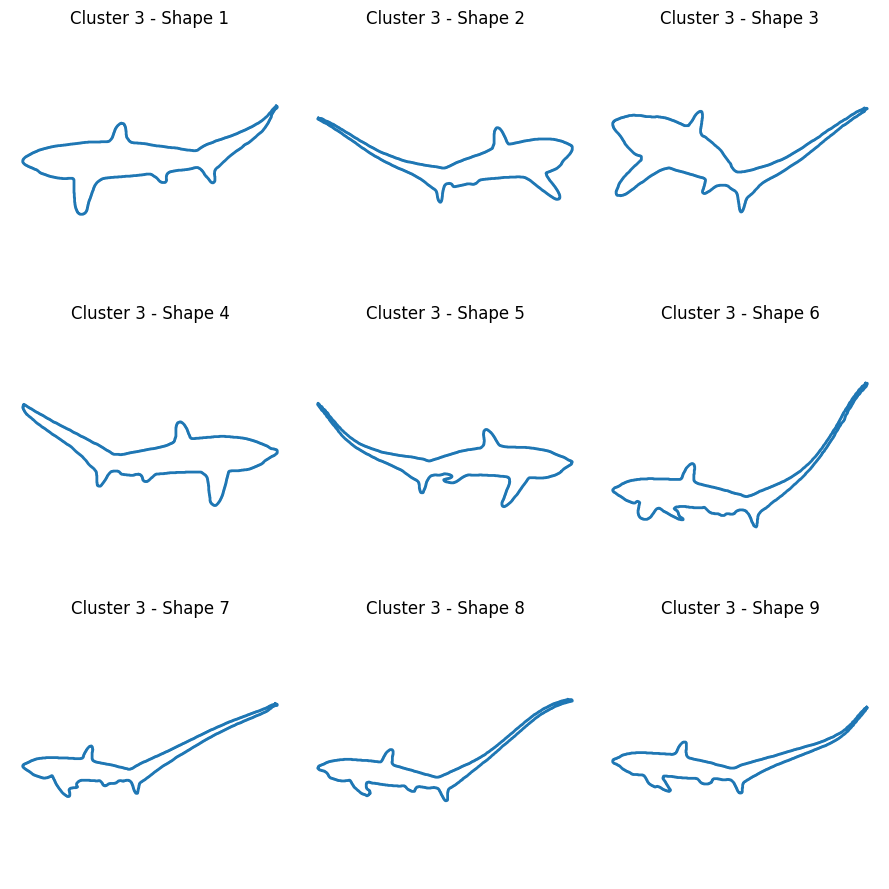

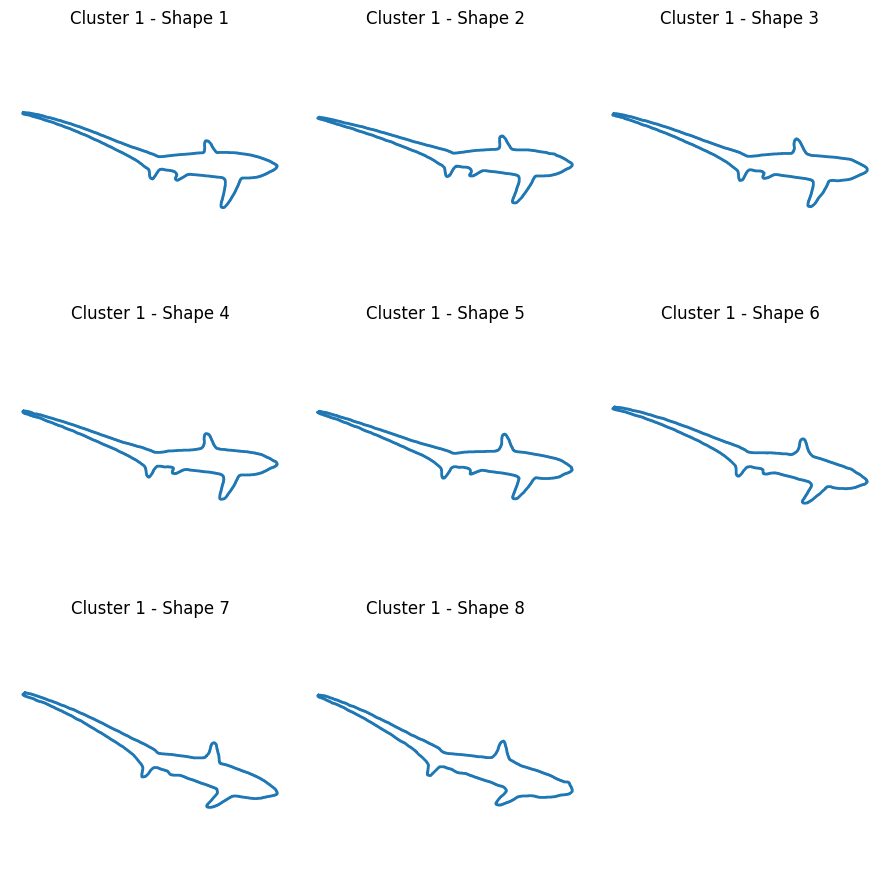

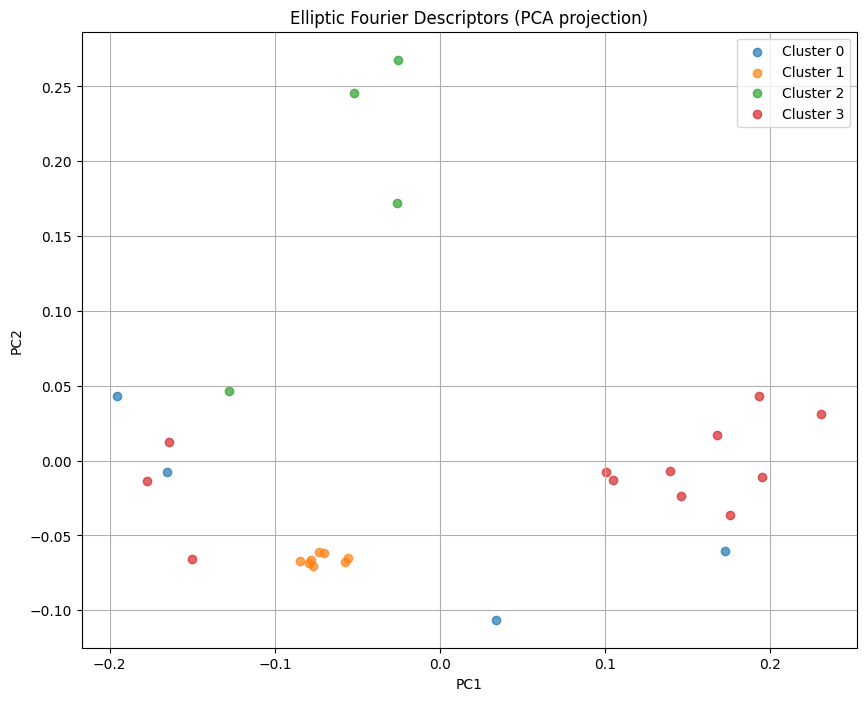

In [40]:
from pyefd import elliptic_fourier_descriptors
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import defaultdict
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# --- Config ---
NUM_CONTOURS_PER_CLUSTER = 9  # for contour visualization
EFD_ORDER = 10

# --- Helper: Extract Largest Contour ---
def extract_largest_contour(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    return largest.squeeze()  # (N, 2)

# --- Process masks and collect EFDs & contours ---
efd_by_cluster = defaultdict(list)
contours_by_cluster = defaultdict(list)
path_to_cluster = {p: int(lbl) for p, lbl in zip(image_paths, cluster_labels) if lbl != -1}


for path in image_paths:
    cluster_id = path_to_cluster.get(path)
    if cluster_id is None:
        continue

    mask_img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        continue

    mask_bin = (mask_img > 0).astype(np.uint8)
    contour = extract_largest_contour(mask_bin)
    if contour is None or len(contour) < 10:
        continue

    efd = elliptic_fourier_descriptors(contour, order=EFD_ORDER, normalize=True).flatten()
    efd_by_cluster[cluster_id].append(efd)

    if len(contours_by_cluster[cluster_id]) < NUM_CONTOURS_PER_CLUSTER:
        contours_by_cluster[cluster_id].append(contour)

# --- Plot raw contours ---
for cluster_id, contour_list in contours_by_cluster.items():
    num = len(contour_list)
    cols = min(3, num)
    rows = (num + cols - 1) // cols

    plt.figure(figsize=(cols * 3, rows * 3))
    for i, contour in enumerate(contour_list):
        plt.subplot(rows, cols, i + 1)
        plt.plot(contour[:, 0], -contour[:, 1], linewidth=2)
        plt.title(f"Cluster {cluster_id} - Shape {i+1}")
        plt.axis("equal")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- EFD PCA Projection ---
all_efds = []
all_labels = []

for cid, efd_list in efd_by_cluster.items():
    for efd in efd_list:
        all_efds.append(efd)
        all_labels.append(cid)

all_efds = np.array(all_efds)
all_labels = np.array(all_labels)

pca = PCA(n_components=2)
efds_pca = pca.fit_transform(all_efds)

plt.figure(figsize=(10, 8))
for cid in np.unique(all_labels):
    idx = all_labels == cid
    plt.scatter(efds_pca[idx, 0], efds_pca[idx, 1], label=f"Cluster {cid}", alpha=0.7)
plt.legend()
plt.title("Elliptic Fourier Descriptors (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [41]:
intra_variance = {}
for cid, efds in efd_by_cluster.items():
    efds_array = np.stack(efds)
    centroid = np.mean(efds_array, axis=0)
    variance = np.mean(np.linalg.norm(efds_array - centroid, axis=1))
    intra_variance[cid] = variance

print("Intra-cluster shape variance:")
for cid, var in intra_variance.items():
    print(f"Cluster {cid}: Variance = {var:.4f}")

Intra-cluster shape variance:
Cluster 2: Variance = 0.1647
Cluster 0: Variance = 0.2237
Cluster 3: Variance = 0.1663
Cluster 1: Variance = 0.0341


Plotting EFD PCA...


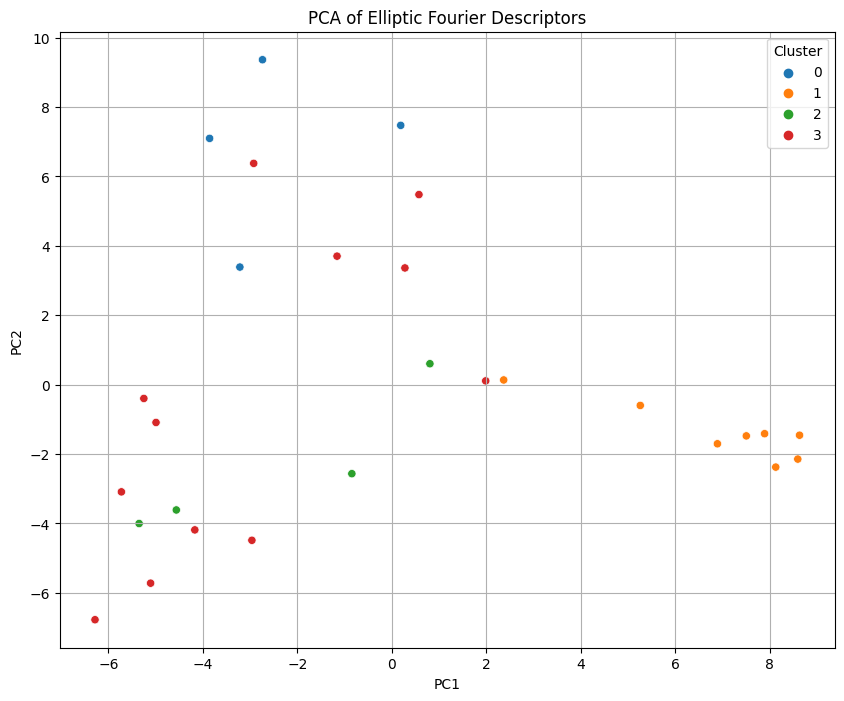

Plotting Hu Moments PCA...


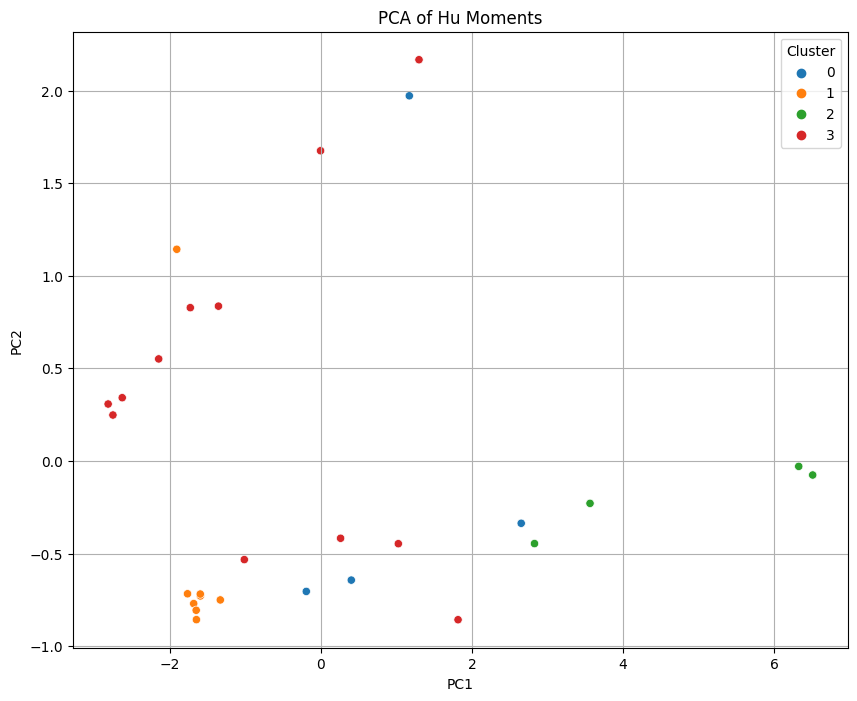

Plotting Radial Signature PCA...


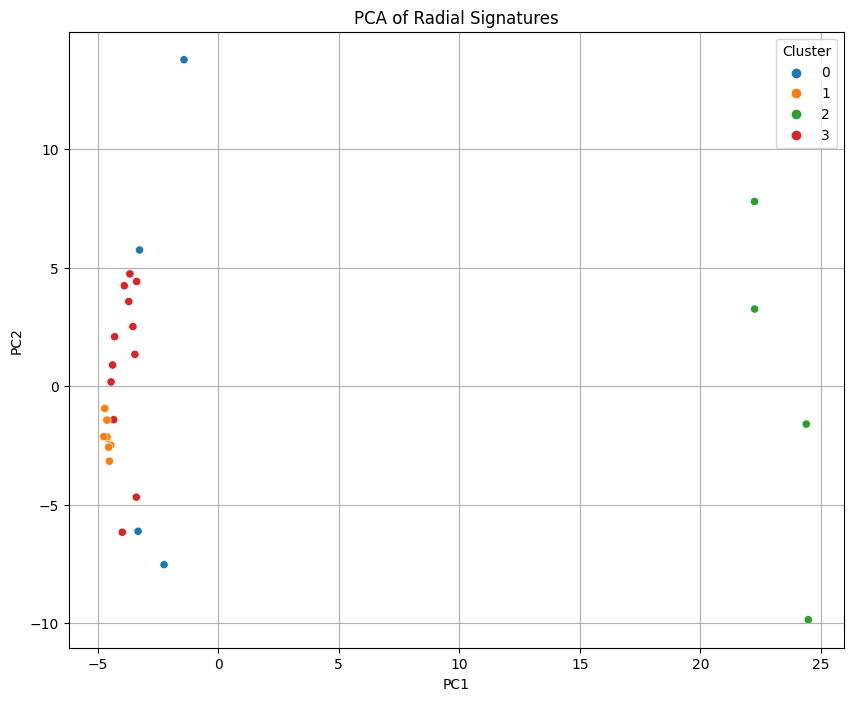


Cluster 0


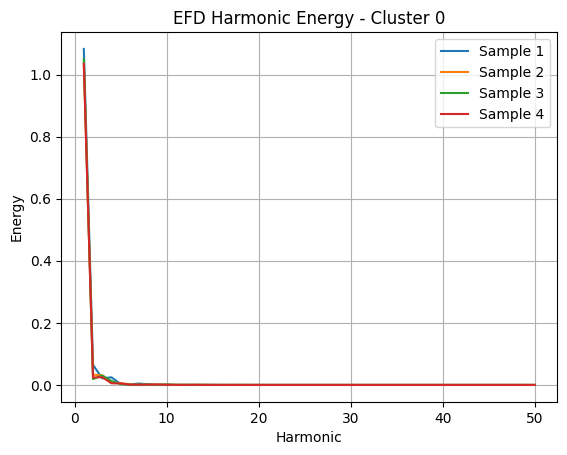

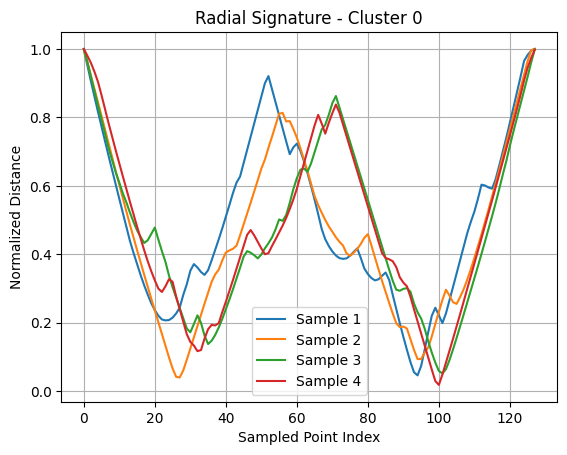


Cluster 1


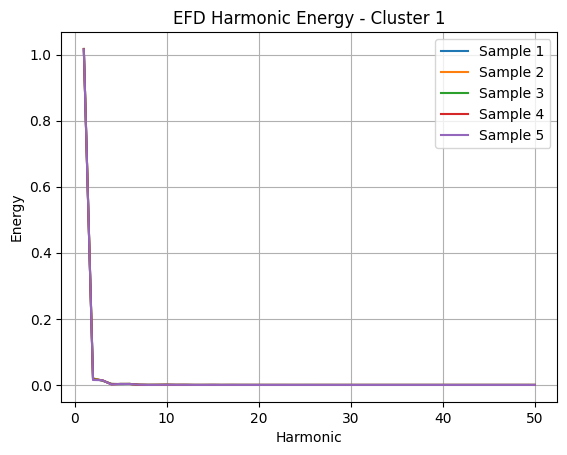

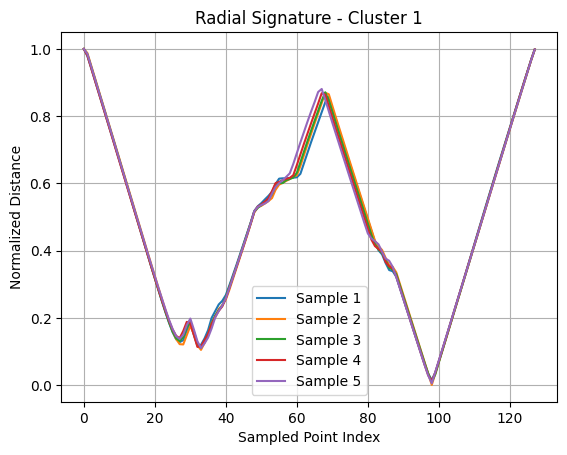


Cluster 2


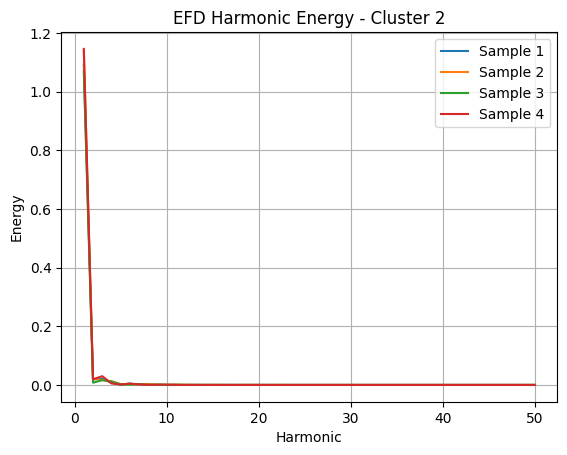

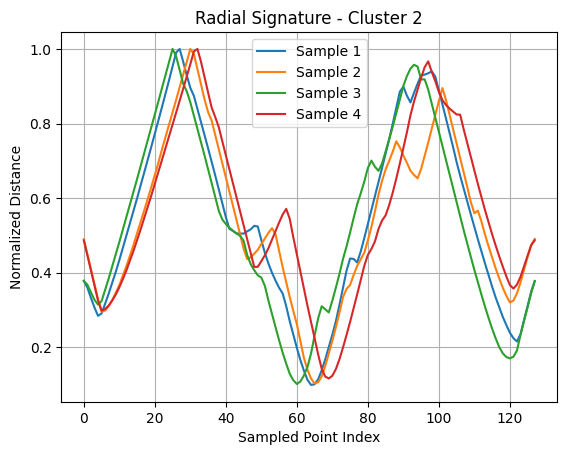


Cluster 3


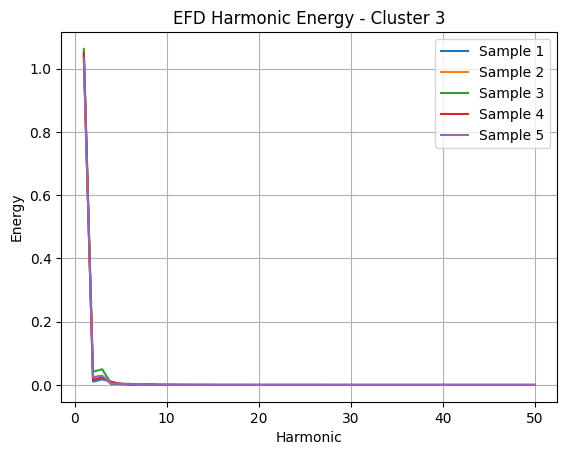

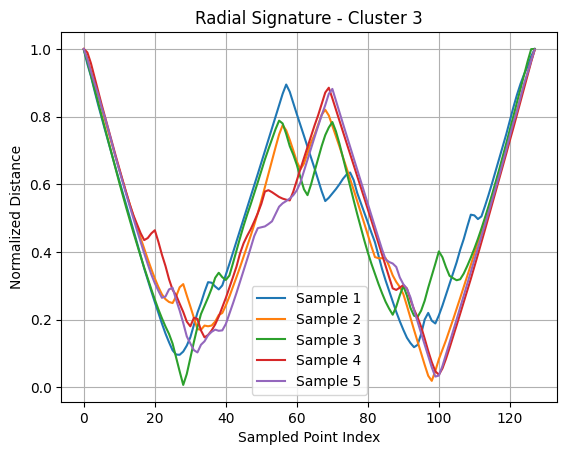

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pyefd import elliptic_fourier_descriptors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import measure
import seaborn as sns

# ========== Config ==========
EFD_ORDER = 50
RADIAL_POINTS = 128
MAX_CONTOURS_PLOT = 5

# ========== Data Structures ==========
efd_by_cluster = defaultdict(list)
hu_by_cluster = defaultdict(list)
radial_by_cluster = defaultdict(list)
contours_by_cluster = defaultdict(list)

# ========== Path to Cluster Map ==========
path_to_cluster = {p: int(lbl) for p, lbl in zip(image_paths, cluster_labels) if lbl != -1}


# ========== Helper Functions ==========
def extract_largest_contour(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    largest = max(contours, key=cv2.contourArea)
    return largest.squeeze()

def get_efd(contour, order=10):
    efd = elliptic_fourier_descriptors(contour, order=order, normalize=True).flatten()
    return efd

def get_hu(contour):
    M = cv2.moments(contour)
    hu = cv2.HuMoments(M).flatten()
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

def get_radial(contour, num_points=128):
    centroid = np.mean(contour, axis=0)
    dists = np.linalg.norm(contour - centroid, axis=1)
    resampled = np.interp(np.linspace(0, len(dists), num_points), np.arange(len(dists)), dists)
    return resampled / np.max(resampled)

# ========== Loop Through Masks ==========
for path in image_paths:
    cluster_id = path_to_cluster.get(path)
    if cluster_id is None:
        continue

    mask_img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask_img is None:
        continue

    mask_bin = (mask_img > 0).astype(np.uint8)
    contour = extract_largest_contour(mask_bin)
    if contour is None or len(contour) < 10:
        continue

    efd_by_cluster[cluster_id].append(get_efd(contour, order=EFD_ORDER))
    hu_by_cluster[cluster_id].append(get_hu(contour))
    radial_by_cluster[cluster_id].append(get_radial(contour, num_points=RADIAL_POINTS))

    if len(contours_by_cluster[cluster_id]) < MAX_CONTOURS_PLOT:
        contours_by_cluster[cluster_id].append(contour)

# ========== PCA Visualization ==========
def plot_descriptor_pca(desc_by_cluster, title):
    all_desc = []
    labels = []
    for cluster_id, descs in desc_by_cluster.items():
        all_desc.extend(descs)
        labels.extend([cluster_id] * len(descs))

    all_desc = np.array(all_desc)
    labels = np.array(labels)

    scaler = StandardScaler()
    desc_scaled = scaler.fit_transform(all_desc)

    pca = PCA(n_components=2)
    desc_pca = pca.fit_transform(desc_scaled)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=desc_pca[:, 0], y=desc_pca[:, 1], hue=labels, palette="tab10")
    plt.title(f"PCA of {title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()

# ========== EFD Harmonic Spectrum ==========
def plot_efd_spectrum(cluster_id, efd_list):
    for i, efd in enumerate(efd_list[:MAX_CONTOURS_PLOT]):
        coeffs = efd.reshape(EFD_ORDER, 4)
        energy = np.linalg.norm(coeffs[:, :2], axis=1)**2 + np.linalg.norm(coeffs[:, 2:], axis=1)**2
        plt.plot(range(1, EFD_ORDER + 1), energy, label=f"Sample {i+1}")
    plt.title(f"EFD Harmonic Energy - Cluster {cluster_id}")
    plt.xlabel("Harmonic")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True)
    plt.show()

# ========== Radial Signature Plot ==========
def plot_radial_signatures(cluster_id, radial_list):
    for i, r in enumerate(radial_list[:MAX_CONTOURS_PLOT]):
        plt.plot(r, label=f"Sample {i+1}")
    plt.title(f"Radial Signature - Cluster {cluster_id}")
    plt.xlabel("Sampled Point Index")
    plt.ylabel("Normalized Distance")
    plt.grid(True)
    plt.legend()
    plt.show()

# ========== Execute All Visualizations ==========
print("Plotting EFD PCA...")
plot_descriptor_pca(efd_by_cluster, "Elliptic Fourier Descriptors")

print("Plotting Hu Moments PCA...")
plot_descriptor_pca(hu_by_cluster, "Hu Moments")

print("Plotting Radial Signature PCA...")
plot_descriptor_pca(radial_by_cluster, "Radial Signatures")

# One-by-one cluster inspection
for cid in sorted(contours_by_cluster.keys())[:5]:  # Show 5 clusters max
    print(f"\nCluster {cid}")
    plot_efd_spectrum(cid, efd_by_cluster[cid])
    plot_radial_signatures(cid, radial_by_cluster[cid])

🔍 PCA of EFDs


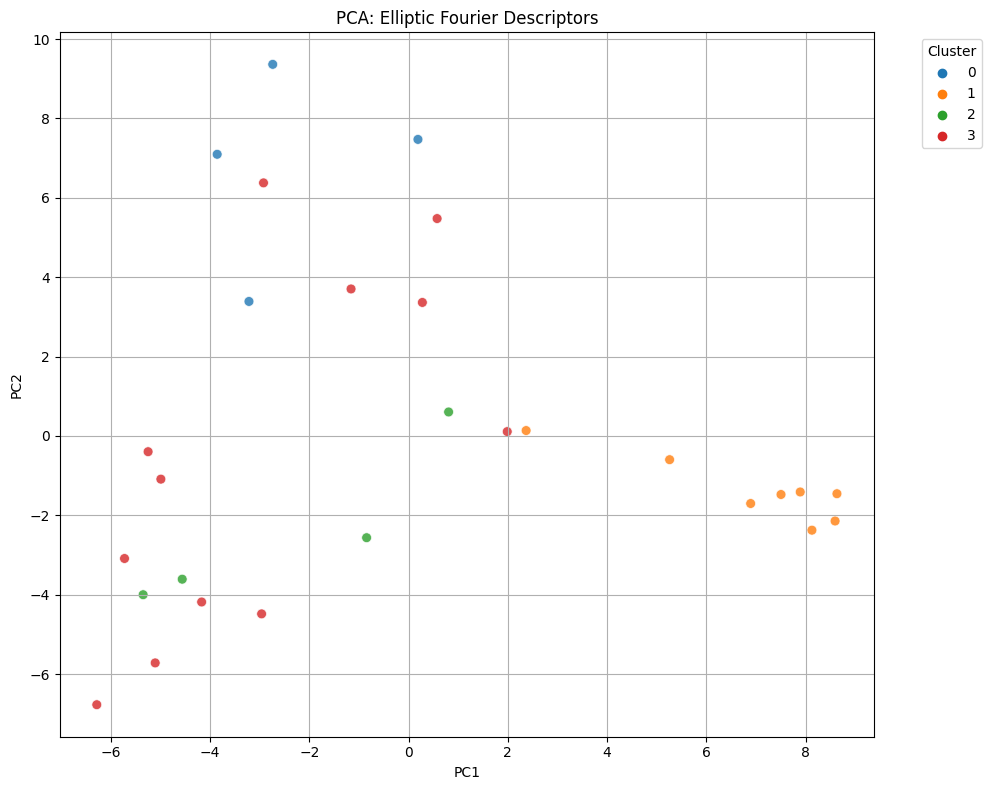

🔍 PCA of Hu Moments


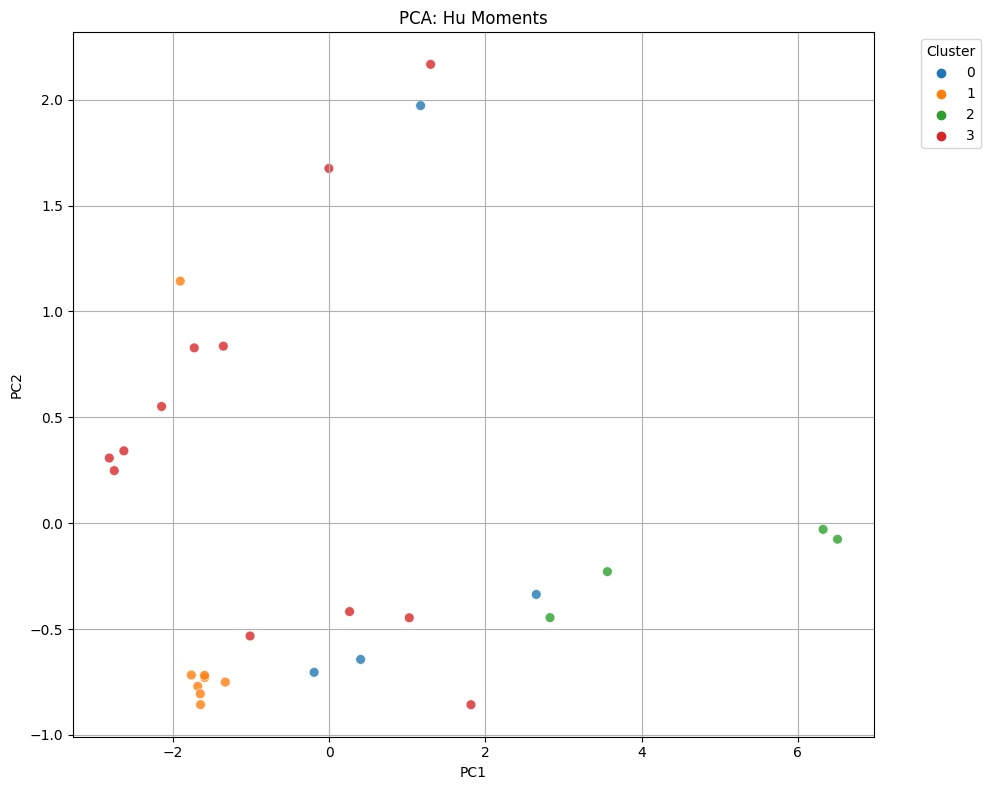

🔍 PCA of Radial Signatures


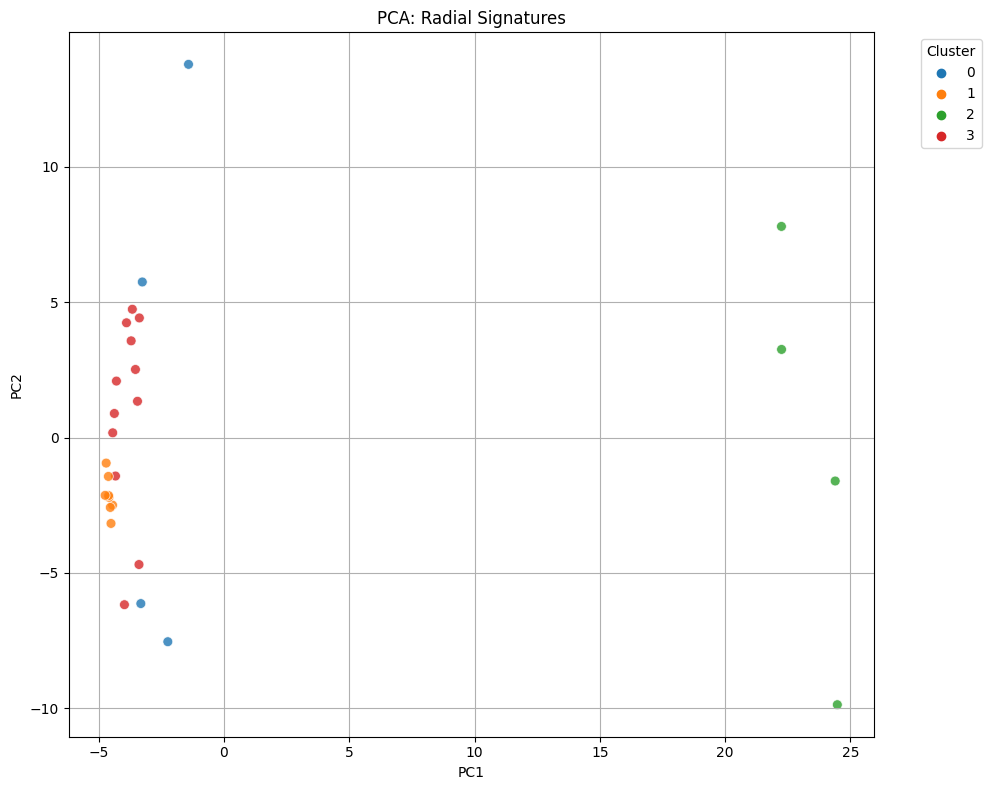

📈 EFD Harmonic Energy Comparison


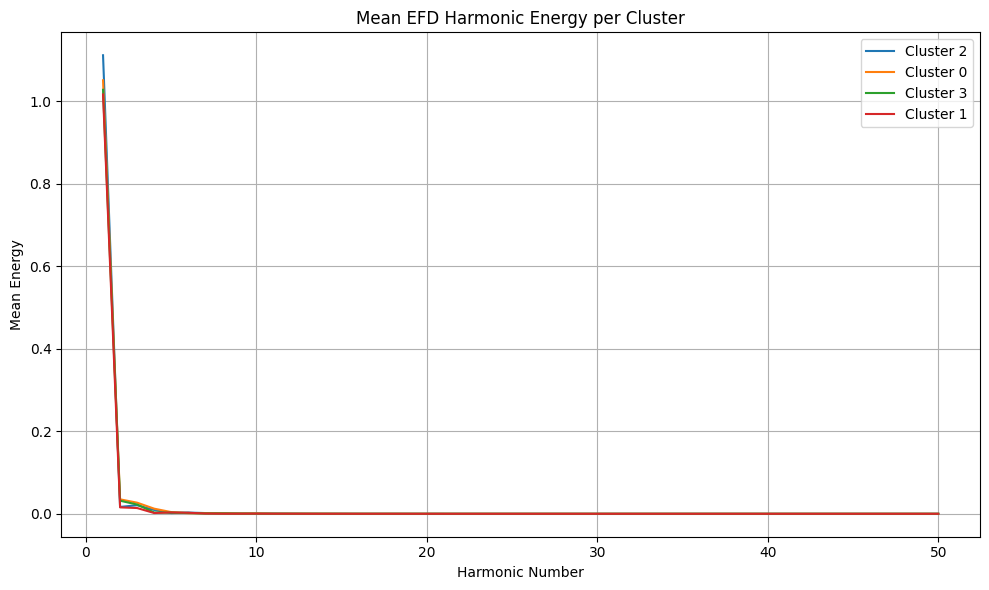

📈 Mean Radial Signature ± Std


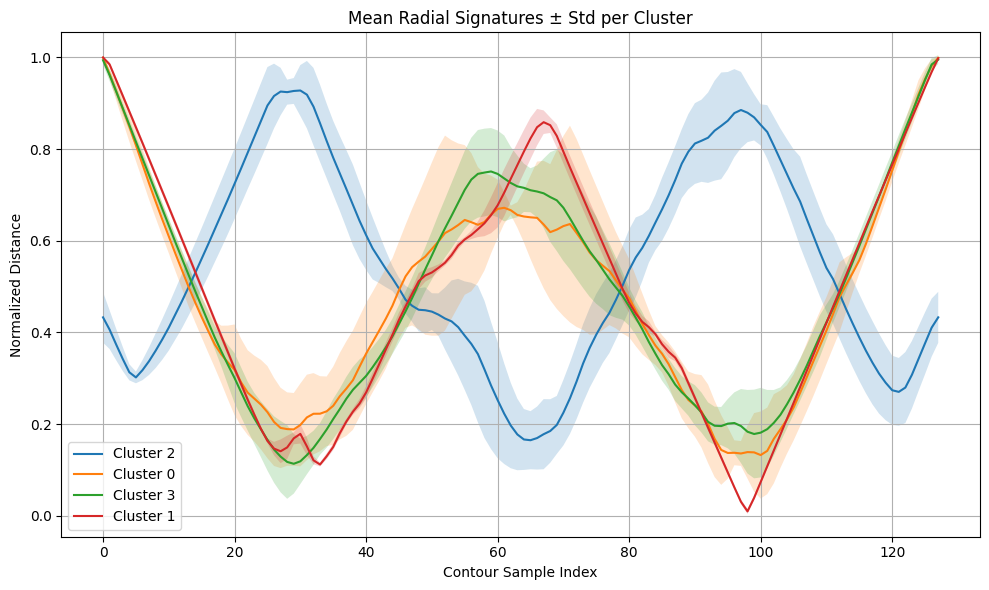

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# === Helper for PCA plot ===
def combined_pca_plot(desc_by_cluster, title):
    all_desc = []
    all_labels = []
    for cid, descs in desc_by_cluster.items():
        all_desc.extend(descs)
        all_labels.extend([cid] * len(descs))

    all_desc = np.array(all_desc)
    all_labels = np.array(all_labels)

    desc_scaled = StandardScaler().fit_transform(all_desc)
    pca = PCA(n_components=2)
    desc_pca = pca.fit_transform(desc_scaled)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=desc_pca[:, 0], y=desc_pca[:, 1], hue=all_labels, palette="tab10", s=50, alpha=0.8)
    plt.title(f"PCA: {title}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Radial Signature Mean ± Std Plot ===
def radial_signature_summary(radial_by_cluster):
    plt.figure(figsize=(10, 6))
    for cid, sigs in radial_by_cluster.items():
        sigs_np = np.array(sigs)
        mean_sig = np.mean(sigs_np, axis=0)
        std_sig = np.std(sigs_np, axis=0)
        x = np.arange(len(mean_sig))
        plt.plot(x, mean_sig, label=f"Cluster {cid}")
        plt.fill_between(x, mean_sig - std_sig, mean_sig + std_sig, alpha=0.2)
    plt.title("Mean Radial Signatures ± Std per Cluster")
    plt.xlabel("Contour Sample Index")
    plt.ylabel("Normalized Distance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === EFD Harmonic Spectrum Comparison ===
def efd_harmonic_comparison(efd_by_cluster, order):
    plt.figure(figsize=(10, 6))
    for cid, efds in efd_by_cluster.items():
        A = np.array(efds).reshape(len(efds), order, 4)
        energy = np.linalg.norm(A[:, :, :2], axis=2)**2 + np.linalg.norm(A[:, :, 2:], axis=2)**2
        mean_energy = np.mean(energy, axis=0)
        plt.plot(range(1, order + 1), mean_energy, label=f"Cluster {cid}")
    plt.title("Mean EFD Harmonic Energy per Cluster")
    plt.xlabel("Harmonic Number")
    plt.ylabel("Mean Energy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Execute All Combined Plots ===
print("🔍 PCA of EFDs")
combined_pca_plot(efd_by_cluster, "Elliptic Fourier Descriptors")

print("🔍 PCA of Hu Moments")
combined_pca_plot(hu_by_cluster, "Hu Moments")

print("🔍 PCA of Radial Signatures")
combined_pca_plot(radial_by_cluster, "Radial Signatures")

print("📈 EFD Harmonic Energy Comparison")
efd_harmonic_comparison(efd_by_cluster, order=EFD_ORDER)

print("📈 Mean Radial Signature ± Std")
radial_signature_summary(radial_by_cluster)

In [ ]:
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np

def analyze_intra_cluster_efd_variation(efd_by_cluster, order=10):
    summary = []

    for cluster_id, efds in efd_by_cluster.items():
        efds = np.array(efds)
        if len(efds) < 2:
            continue

        # Compute pairwise distances (Euclidean) in normalized EFD space
        dists = pdist(efds, metric='euclidean')
        mean_dist = np.mean(dists)
        std_dist = np.std(dists)

        summary.append({
            "cluster": cluster_id,
            "num_shapes": len(efds),
            "mean_intra_dist": mean_dist,
            "std_intra_dist": std_dist
        })

        # Optional: plot histogram of distances
        plt.figure(figsize=(6, 4))
        plt.hist(dists, bins=20, alpha=0.7, color="steelblue")
        plt.title(f"Intra-cluster EFD Distance Distribution - Cluster {cluster_id}")
        plt.xlabel("EFD Euclidean Distance")
        plt.ylabel("Count")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return summary

efd_summary = analyze_intra_cluster_efd_variation(efd_by_cluster, order=EFD_ORDER)

# Print table
import pandas as pd
df_efd = pd.DataFrame(efd_summary)
df_efd = df_efd.sort_values(by="mean_intra_dist", ascending=False)
display(df_efd)